<a href="https://colab.research.google.com/github/mirpouya/Western-University/blob/main/Advance_Image_Processing_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorch has CIFAR-10 dataset in its library, I'm going to use the embedded CIFAR-10 for this assignment.

In [13]:
# importing required libraries

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

"torchvision.transform" is used for common image transformation on applied to PIL images, tensors representing images, or batches of images. Some of these transformations include:
* Resizing
* Cropping
* Rotation
* Flipping
* Converting to tensor
* Normalizing pixel values

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform= transform)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform= transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [9]:
type(trainset)

torchvision.datasets.cifar.CIFAR10

In [11]:
# making dataloaders to iterate through batches of dataset
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True, num_workers=2)

In [12]:
# get the classes in the dataset
classes = trainloader.dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [19]:
# function to visualize images in dataloaders

def data_loader_imshow(img):
    np_img = img.numpy()   # from tensor to numpy since matplotlib accepts only numpy arrays
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

In image processing it is a tradition to represent an RGB image with (channels, height, width), however, matplotlib expect an image in the format of (height, width, channels). This is why I did
 `np.transpose(npimg, (1, 2, 0))`.


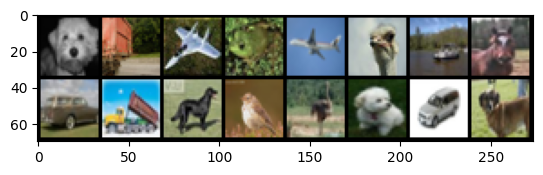

In [20]:
# visualize training data

# iterating through trainloader
for images, labels in trainloader:
    # Visualize images
    data_loader_imshow(torchvision.utils.make_grid(images))
    break

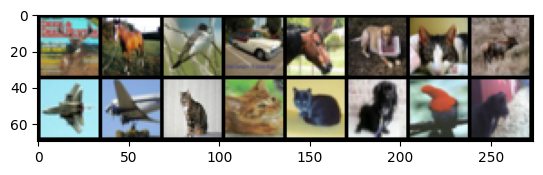

In [23]:
# visualize test data

for images, label in testloader:
  data_loader_imshow(torchvision.utils.make_grid(images))
  break